# Customer clustering

## Loading libraries/packages

In [243]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Data from: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data
# Goal: Cluster customers based on demographic data.

## Importing data + dealing with missing data:

In [244]:
# Import data:
df = pd.read_csv("/Users/paulinecuperus/Downloads/marketing_campaign.csv", sep = "\t")
print(df.head())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

In [245]:
# Check data types:
print(df.info())
# All as correct data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [246]:
# Check missing data: 
print(df.isnull().sum())

# There are only 24 rows with missing data.
# Are these missing completely at random? Check how they compare to others:
print(df[df["Income"].isnull()].describe())
print(df[df["Income"].isnull() == False].describe())

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64
                 ID   Year_Birth  Income    Kidhome   Teenhome    Recency  \
count     24.000000    24.000000     0.0  24.000000  24.000000  24.000000   
mean    5943.625000  1967.458333     NaN   0.666667   0.583333  58.041667   
st

I don't see any worrying trends here.
I do notice, however, that there are no people that have indicated that they have "0" income. I'm wondering whether this might be the case for people that have missing data for the "income" column. This may be related to how much people have spent (i.e. we would expect people with low income may spent less). 

In [247]:
# Check how much the total spending amount is in both categories:
df["Amount_Spent"] = df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
print(df[df["Income"].isnull()]["Amount_Spent"].describe())
print(df[df["Income"].isnull() == False]["Amount_Spent"].describe())

count      24.000000
mean      290.666667
std       400.495961
min        11.000000
25%        26.000000
50%        94.500000
75%       403.250000
max      1647.000000
Name: Amount_Spent, dtype: float64
count    2216.000000
mean      301.983755
std       337.632733
min         1.000000
25%        42.000000
50%       143.500000
75%       486.250000
max      1729.000000
Name: Amount_Spent, dtype: float64


The two groups are very similar in spending patterns. Still, I can think of reasons why they might have "0" income and have this type of spending pattern (e.g. they just got laid off and are living off savings). I cannot be certain that the data are missing completely at random. I will therefore delete all rows with missing data:

In [248]:
df = df.dropna()

# Exploratory data analysis + data preprocessing

### Birth year

Rather than having customers' year of birth. I would like to change this to a column that has customers' age. I'm not sure when the data were collected, but will assume (this is a guess) that the youngest customer in the dataset was 18 at the time of data collection.

In [249]:
print(df["Year_Birth"].max())

1996


Hightest Year_Birth is 1996, so I'll assume that the data was collected in 1996 + 18 = 2014. I will therefore drop all rows where the "Year_Birth" value is <= 1914. I assume these are errors, as it is unlikely that there are any customers over the age of 100.

In [250]:
df = df[df["Year_Birth"] >= 1914]
df["Age"] = 2014 - df["Year_Birth"]

I might want to look at age categories rather than age as a numeric variable during the analysis. Just in case, I will create different age brackets:

In [251]:
# Bin data into age groups: 
bin_boundaries = [0, 31, 41, 51, 61, 100]
bin_labels = ["18-30", "31-40", "41-50", "51-60", "60+"]

df["age_bin"] = pd.cut(df["Age"], bins = bin_boundaries, labels = bin_labels, include_lowest = True, right = False)

##### Visualising customers' ages:

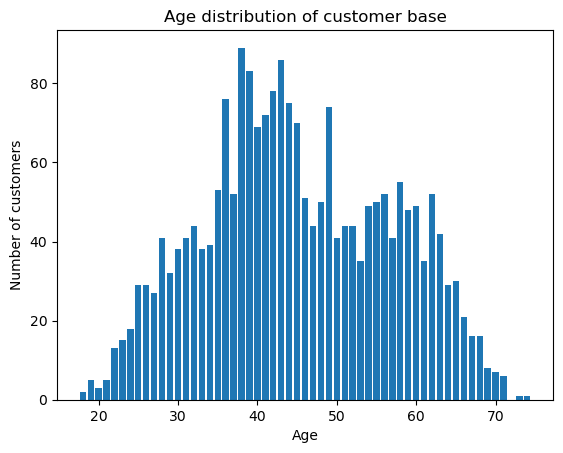

In [252]:
df2 = df["Age"].value_counts().reset_index()
plt.bar(df2["Age"], df2["count"])
plt.title("Age distribution of customer base")
plt.xlabel("Age")
plt.ylabel("Number of customers")
plt.show()

### Level of education:

In [253]:
# View distribution across categories:
print(df["Education"].value_counts())

Education
Graduation    1116
PhD            480
Master         365
2n Cycle       198
Basic           54
Name: count, dtype: int64


Note that there are very few people in the "Basic" category. I would like to divide this feature into larger groups, but I do not understand the meaning of the different categories. I worry I may divide them incorrectly and so will not change this variable.

#### Visualise level of education

/Users/paulinecuperus/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


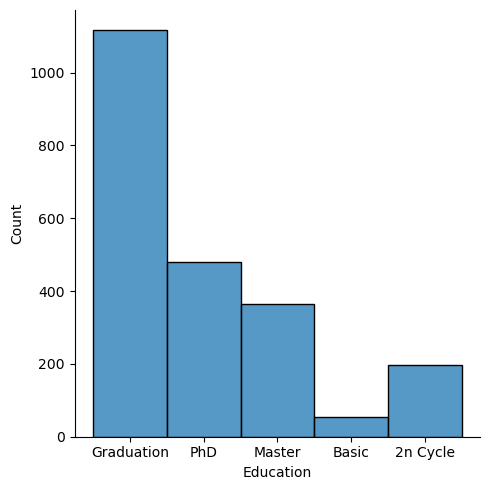

In [254]:
sns.displot(df, x = "Education")

### Marital status

In [255]:
print(df["Marital_Status"].value_counts())

Marital_Status
Married     857
Together    572
Single      470
Divorced    231
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


There are many smaller categories here. I will change this to only two categories: In a relationship yes/no:

In [256]:
df["Marital_Status"] = df["Marital_Status"].replace({"Married": "In a relationship", "Together": "In a relationship", "Single": "Not in a relationship", "Divorced": "Not in a relationship", "Widow": "Not in a relationship", "Alone": "Not in a relationship", "Absurd": "Not in a relationship", "YOLO": "Not in a relationship"})

Based on marital status, we can calculate the number of adults in a household. I'd like to save this as a separate variable:

In [257]:
df["Number_of_Adults"] = df.apply(lambda x: 2 if x["Marital_Status"] == "In a relationship" else 1, axis = 1)
print(df["Number_of_Adults"].value_counts())

Number_of_Adults
2    1429
1     784
Name: count, dtype: int64


#### Visualise marital status:

/Users/paulinecuperus/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


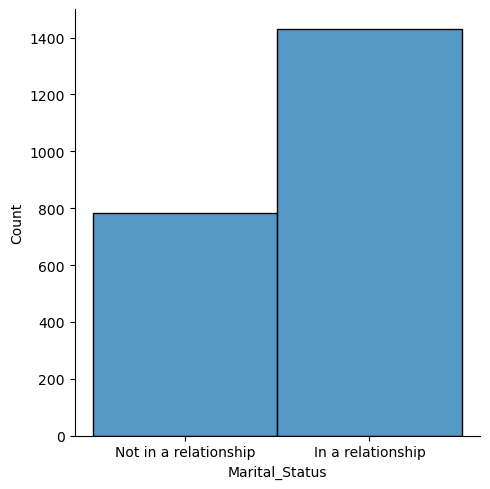

In [258]:
sns.displot(df, x = "Marital_Status")

### Income

#### Visualise income

Text(0, 0.5, 'Household income')

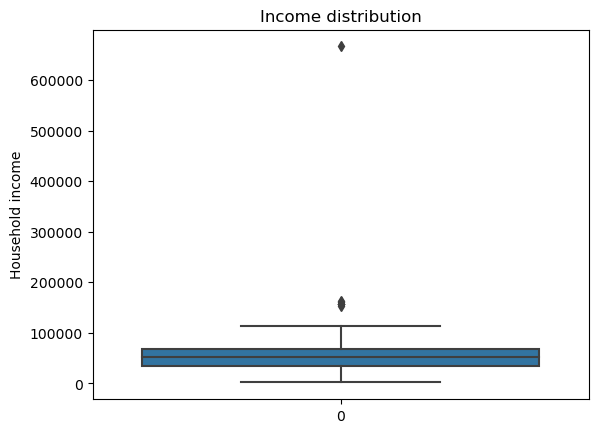

In [259]:
sns.boxplot(df["Income"])
plt.title("Income distribution")
plt.ylabel("Household income")

There is one very clear outlier in the data, which I will remove:

Text(0, 0.5, 'Household income')

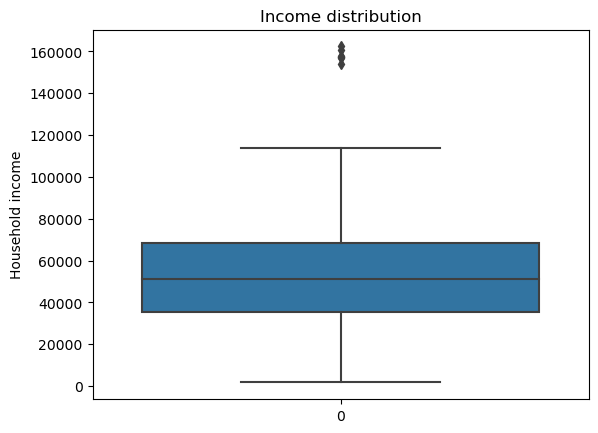

In [260]:
# There is one very clear outlier in the data. I will remove this:
df = df[df["Income"] < 500000]

# Visualise with outlier removed:
sns.boxplot(df["Income"])
plt.title("Income distribution")
plt.ylabel("Household income")

Some outliers remaining. I will keep these in as:
- They are valid data points.
- There's not so many that they will have a large effect on the analysis, but enough close together for it to be a potential customer cluster.

### Number of children / teenagers

In [261]:
# Explore distribution:
print(df["Kidhome"].value_counts())
print(df["Teenhome"].value_counts())

Kidhome
0    1281
1     885
2      46
Name: count, dtype: int64
Teenhome
0    1144
1    1017
2      51
Name: count, dtype: int64


I would like to create some additional variables here:
- Total number of minors (children + teens)
- Household size (adults + minors)
- Binary variable: Are there minors yes or no? (I might want to explore this as an alternative to the number of minors in further analysis.

In [262]:
# Number of minors variable:
df["Number_of_Minors"] = df["Kidhome"] + df["Teenhome"]
print(df["Number_of_Minors"].value_counts())

# Household size variable: 
df["Household_Size"] = df["Number_of_Adults"] + df["Number_of_Minors"]

# Minors present yes/no variable:
df["Minors_Binary"] = df.apply(lambda x: 1 if x["Number_of_Minors"] in [1, 2, 3] else 0, axis = 1)
print(df["Minors_Binary"].value_counts())

Number_of_Minors
1    1114
0     632
2     416
3      50
Name: count, dtype: int64
Minors_Binary
1    1580
0     632
Name: count, dtype: int64


### Sign up date

Worth further exploring: If people have only just signed up, we might want to use targeted marketing to ensure that they are retained as customers. I'd like to have this as a days since signing up, rather than the sign up date itself:

In [263]:
# Change to days since signing up:
df["Days_Since_Signing_Up"] = df.apply(lambda x: ((datetime.datetime.strptime("31-12-2014", "%d-%m-%Y")) - (datetime.datetime.strptime(x["Dt_Customer"], "%d-%m-%Y"))).days, axis = 1)

This is a good time to check my previous assumption that the data are from 2014:

In [264]:
print(df["Days_Since_Signing_Up"].describe())

count    2212.000000
mean      538.714286
std       202.494886
min       185.000000
25%       365.000000
50%       541.000000
75%       714.000000
max       884.000000
Name: Days_Since_Signing_Up, dtype: float64


This assumption seems accurate with the lowest value being 185 days.

##### Visualise distribution:

Text(0, 0.5, 'Days since signing up as customer')

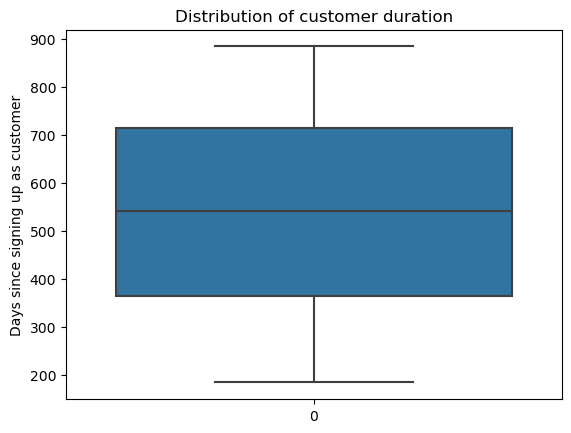

In [265]:
# Check distribution:
sns.boxplot(df["Days_Since_Signing_Up"])
plt.title("Distribution of customer duration")
plt.ylabel("Days since signing up as customer")
# No outliers.

### Recency

Check distribution:

In [266]:
print(df["Recency"].describe())

count    2212.000000
mean       49.019439
std        28.943121
min         0.000000
25%        24.000000
50%        49.000000
75%        74.000000
max        99.000000
Name: Recency, dtype: float64


##### Visualise recency:

Text(0, 0.5, 'Days')

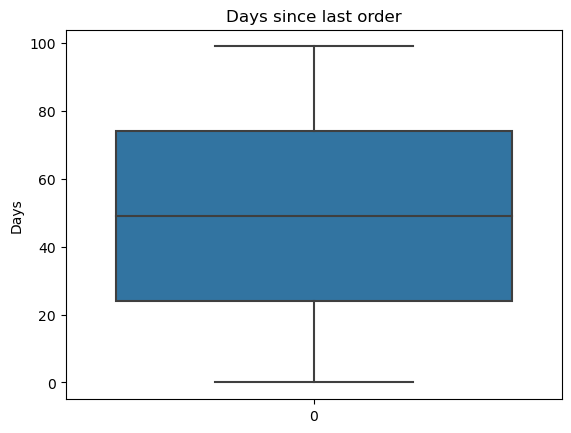

In [267]:
sns.boxplot(df["Recency"])
plt.title("Days since last order")
plt.ylabel("Days")
# No outliers.

### Amount spent

Rather than having this in five separate colmns, I would like this to be in a single column that sums up customers' total spending:

In [268]:
df["Amount_Spent"] = df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

##### Visualise amount spent

<Axes: >

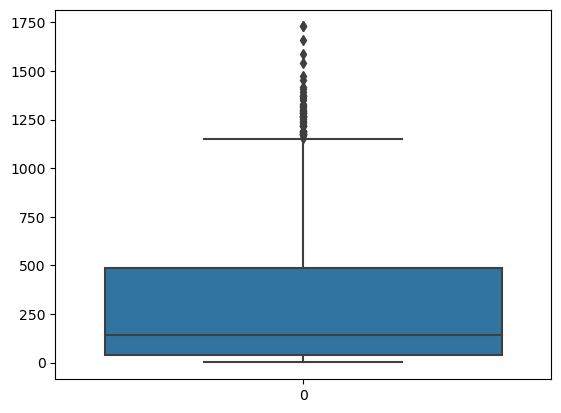

In [269]:
sns.boxplot(df["Amount_Spent"])

There are some outliers here. While K means clustering is relatively sensitive to outliers, I have compared the model I run later with and without and outliers have very little impact. I will leave them in (the outliers could be a separate cluster).

### Promotions accepted

I would like to have this in two ways:
1) A single variable that calculates the total number of promotions that the customer accepted.
2) A binary value that indicates whether the customer has ever accepted a promotion (1) or has never accepted a promotion (0).

In [270]:
# 1)
df["#_Accepted_Promotions"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"]

# 2)
df["Accepts_Promotions"] = df.apply(lambda x: 1 if x["#_Accepted_Promotions"] > 0 else 0, axis = 1)

Checking the distribution / counts of these variables:

In [273]:
print(df["#_Accepted_Promotions"].describe())
print(df["Accepts_Promotions"].value_counts())

count    2212.000000
mean        0.298373
std         0.679570
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: #_Accepted_Promotions, dtype: float64
Accepts_Promotions
0    1754
1     458
Name: count, dtype: int64


### Purchasing means

It looks like there are three ways of purchasing: Web, Catalogue, and Store. I would like to store the main means of purchasing for each customer.

In [274]:
# Create new variable with main means of purchasing:
df["Main_Purchase_Means"] = df.apply(lambda x: "Web" if ((x["NumWebPurchases"] > x["NumCatalogPurchases"]) & (x["NumWebPurchases"] > x["NumStorePurchases"])) else "Catalog" if ((x["NumCatalogPurchases"] > x["NumWebPurchases"]) & (x["NumCatalogPurchases"] > x["NumStorePurchases"])) else "Store" if ((x["NumStorePurchases"] > x["NumCatalogPurchases"]) & (x["NumStorePurchases"] > x["NumWebPurchases"])) else "Combination", axis = 1)

In [275]:
# Check distribution across categories:
print(df["Main_Purchase_Means"].value_counts())

Main_Purchase_Means
Store          1459
Web             323
Combination     295
Catalog         135
Name: count, dtype: int64


### Checking data types of new columns + deleting redundant columns

In [276]:
print(df.info())
# Change minors_binary and accepts_promotions:
df["Minors_Binary"] = df["Minors_Binary"].astype("category")
df["Accepts_Promotions"] = df["Accepts_Promotions"].astype("category")

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ID                     2212 non-null   int64   
 1   Year_Birth             2212 non-null   int64   
 2   Education              2212 non-null   object  
 3   Marital_Status         2212 non-null   object  
 4   Income                 2212 non-null   float64 
 5   Kidhome                2212 non-null   int64   
 6   Teenhome               2212 non-null   int64   
 7   Dt_Customer            2212 non-null   object  
 8   Recency                2212 non-null   int64   
 9   MntWines               2212 non-null   int64   
 10  MntFruits              2212 non-null   int64   
 11  MntMeatProducts        2212 non-null   int64   
 12  MntFishProducts        2212 non-null   int64   
 13  MntSweetProducts       2212 non-null   int64   
 14  MntGoldProds           2212 non-null   int64 

In [277]:
# Drop columns that I won't be using:
df = df.drop(columns = ["Dt_Customer", "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds", "NumDealsPurchases", "NumWebPurchases", "NumStorePurchases", "NumCatalogPurchases", "NumWebVisitsMonth", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "AcceptedCmp1", "AcceptedCmp2", "Z_CostContact", "Z_Revenue", "Response"])
print(df.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'Complain', 'Amount_Spent', 'Age', 'age_bin',
       'Number_of_Adults', 'Number_of_Minors', 'Household_Size',
       'Minors_Binary', 'Days_Since_Signing_Up', '#_Accepted_Promotions',
       'Accepts_Promotions', 'Main_Purchase_Means'],
      dtype='object')


## Data transformation

In [278]:
# Label encode the categorical variables:
label_encoder_education = LabelEncoder()
df["Education"] = label_encoder_education.fit_transform(df["Education"])

label_encoder_marital_status = LabelEncoder()
df["Marital_Status"] = label_encoder_marital_status.fit_transform(df["Marital_Status"])

label_encoder_promotions = LabelEncoder()
df["Accepts_Promotions"] = label_encoder_promotions.fit_transform(df["Accepts_Promotions"])

label_encoder_age = LabelEncoder()
df["age_bin"] = label_encoder_age.fit_transform(df["age_bin"])

label_encoder_means = LabelEncoder()
df["Main_Purchase_Means"] = label_encoder_means.fit_transform(df["Main_Purchase_Means"])

In [279]:
# Check
print(df.head())
# Complete

     ID  Year_Birth  Education  Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957          2               1  58138.0        0         0   
1  2174        1954          2               1  46344.0        1         1   
2  4141        1965          2               0  71613.0        0         0   
3  6182        1984          2               0  26646.0        1         0   
4  5324        1981          4               0  58293.0        1         0   

   Recency  Complain  Amount_Spent  Age  age_bin  Number_of_Adults  \
0       58         0           982   57        3                 1   
1       38         0            16   60        3                 1   
2       26         0           350   49        2                 2   
3       26         0            42   30        0                 2   
4       94         0           249   33        1                 2   

   Number_of_Minors  Household_Size Minors_Binary  Days_Since_Signing_Up  \
0                 0               

In [280]:
# Scale numeric data:
standard_scaler = StandardScaler()
df["Proportion_Income_Spent"] = df["Amount_Spent"] / df["Income"] 
df[["Proportion_Income_Spent", "Income", "Recency", "Days_Since_Signing_Up", "Age", "Household_Size", "Amount_Spent", "#_Accepted_Promotions"]] = standard_scaler.fit_transform(df[["Proportion_Income_Spent", "Income", "Recency", "Days_Since_Signing_Up", "Age", "Household_Size", "Amount_Spent", "#_Accepted_Promotions"]])

In [281]:
# Check:
print(df.head())
# Complete

     ID  Year_Birth  Education  Marital_Status    Income  Kidhome  Teenhome  \
0  5524        1957          2               1  0.287105        0         0   
1  2174        1954          2               1 -0.260882        1         1   
2  4141        1965          2               0  0.913196        0         0   
3  6182        1984          2               0 -1.176114        1         0   
4  5324        1981          4               0  0.294307        1         0   

    Recency  Complain  Amount_Spent  ...  age_bin  Number_of_Adults  \
0  0.310353         0      2.016080  ...        3                 1   
1 -0.380813         0     -0.847858  ...        3                 1   
2 -0.795514         0      0.142365  ...        2                 2   
3 -0.795514         0     -0.770775  ...        0                 2   
4  1.554453         0     -0.157074  ...        1                 2   

   Number_of_Minors  Household_Size  Minors_Binary Days_Since_Signing_Up  \
0                 0   

### Clustering

I will try out several combinations of features and includes the highest number of informative features and has the relatively lowest SSE.

In [282]:
# Option 1: Using as many features as possible:
columns_to_include_1 = ["Education", "Income", "Age", "Household_Size", "Days_Since_Signing_Up", "Amount_Spent", "Accepts_Promotions", "Main_Purchase_Means", "Recency"]
# SSE at 4: 11800. SSE at 6: 10600

# Option 2: Education left out here due to unclarity of what categories mean (and therefore inability to regroup
# meaningfully):
columns_to_include_2 = ["Income", "Age", "Household_Size", "Days_Since_Signing_Up", "Amount_Spent", "Accepts_Promotions", "Main_Purchase_Means", "Recency"]
# SSE at 4: 9500. SSE at 6: 8200

# Option 3: 
# Rather than including "Household_Size", include Marital_Status and Minors_Binary:
columns_to_include_3 = ["Education", "Income", "Age", "Marital_Status", "Minors_Binary", "Days_Since_Signing_Up", "Amount_Spent", "Accepts_Promotions", "Main_Purchase_Means", "Recency"]
# SSE at 4: 11000. SSE at 6: 10000

# Option 4: Use "age_bin" instead of age as numeric variable:
columns_to_include_4 = ["Education", "Income", "age_bin", "Household_Size", "Days_Since_Signing_Up", "Amount_Spent", "Accepts_Promotions", "Main_Purchase_Means", "Recency"]
# SSE at 4: 12200. SSE at 6: 11600

# Option 5: Use Number of promotions instead of "accepts_promotions":
columns_to_include_5 = ["Education", "Income", "Age", "Household_Size", "Days_Since_Signing_Up", "Amount_Spent", "#_Accepted_Promotions", "Main_Purchase_Means", "Recency"]
# SSE at 4: 12800. SSE at 6: 11800

# COMBINE BEST: 1) Leave out education; 2) use "Marital_Status" and "Minors_Binary" instead of "Household_Size"
columns_to_include_final = ["Income", "Age", "Marital_Status", "Minors_Binary", "Days_Since_Signing_Up", "Amount_Spent", "Accepts_Promotions", "Main_Purchase_Means", "Recency"]
# SSE at 4: 8500. SSE at 6: 7500

# UPDATE: The initial clustering showed that "Recency" is not a very informative feature. Re-run without:
columns_to_include_updated = columns_to_include_final = ["Income", "Age", "Marital_Status", "Minors_Binary", "Days_Since_Signing_Up", "Amount_Spent", "Accepts_Promotions", "Main_Purchase_Means"]
# SSE at 4: 6200. SSE at 6: 5500

# Use updated combination of features

In [283]:
# Use elbow method to determine best possible n:

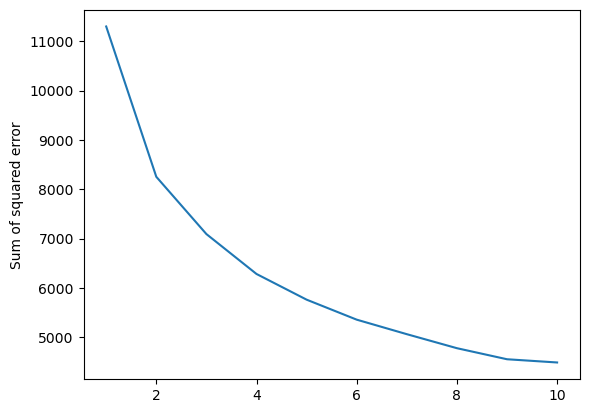

In [284]:
k_range = range(1, 11)
SSE = []

for k in k_range:
    km = KMeans(n_clusters = k, n_init = "auto")
    km.fit(df[columns_to_include_updated])
    SSE.append(km.inertia_)

# Visualise this:
plt.plot(k_range, SSE)
plt.ylabel("Sum of squared error")
plt.show()

# I choose 6

In [285]:
# Run model:
km = KMeans(n_clusters = 6)

In [286]:
# Get cluster per customer:
y_pred = km.fit_predict(df[columns_to_include_updated])

# Add this as a separate column to the dataframe:
df["Cluster"] = y_pred

/Users/paulinecuperus/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [287]:
# Check distribution of clusters:
print(df["Cluster"].value_counts())
# Relatively even (although 3 smaller than other categories)

Cluster
3    445
0    432
4    396
1    377
5    313
2    249
Name: count, dtype: int64


### Analyse outcome

In [288]:
# Get back the original values before transformation:
df["Marital_Status"] = label_encoder_marital_status.inverse_transform(df["Marital_Status"])
df["Accepts_Promotions"] = label_encoder_promotions.inverse_transform(df["Accepts_Promotions"])
df["age_bin"] = label_encoder_age.inverse_transform(df["age_bin"])
df["Main_Purchase_Means"] = label_encoder_means.inverse_transform(df["Main_Purchase_Means"])

df[["Proportion_Income_Spent", "Income", "Recency", "Days_Since_Signing_Up", "Age", "Household_Size", "Amount_Spent", "#_Accepted_Promotions"]] = standard_scaler.inverse_transform(df[["Proportion_Income_Spent", "Income", "Recency", "Days_Since_Signing_Up", "Age", "Household_Size", "Amount_Spent", "#_Accepted_Promotions"]])
print(df.head())

     ID  Year_Birth  Education         Marital_Status   Income  Kidhome  \
0  5524        1957          2  Not in a relationship  58138.0        0   
1  2174        1954          2  Not in a relationship  46344.0        1   
2  4141        1965          2      In a relationship  71613.0        0   
3  6182        1984          2      In a relationship  26646.0        1   
4  5324        1981          4      In a relationship  58293.0        1   

   Teenhome  Recency  Complain  Amount_Spent  ...  Number_of_Adults  \
0         0     58.0         0         982.0  ...                 1   
1         1     38.0         0          16.0  ...                 1   
2         0     26.0         0         350.0  ...                 2   
3         0     26.0         0          42.0  ...                 2   
4         0     94.0         0         249.0  ...                 2   

  Number_of_Minors  Household_Size  Minors_Binary  Days_Since_Signing_Up  \
0                0             1.0            

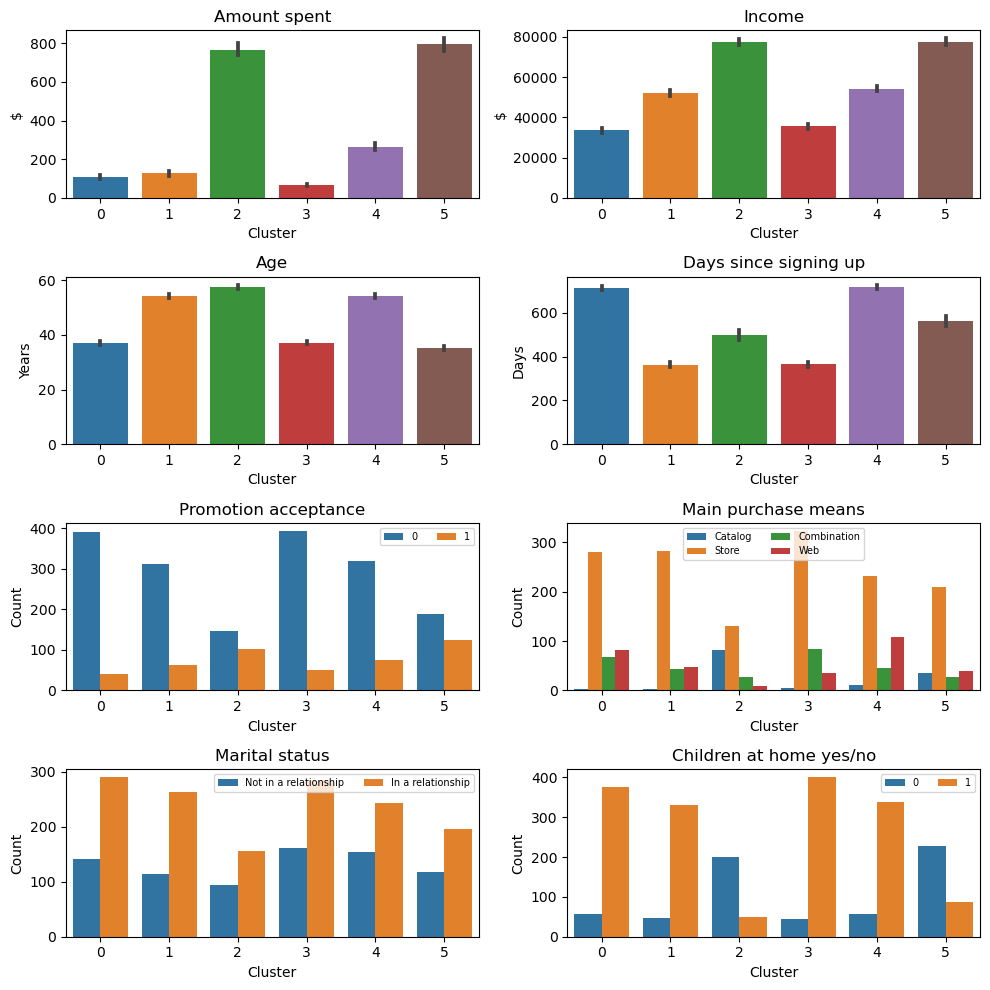

In [289]:
# Visualise the different groups in terms of the features that were included:
fig, axs = plt.subplots(4, 2, figsize = (10, 10))

sns.barplot(df, x = "Cluster", y = "Amount_Spent", ax = axs[0, 0])
axs[0, 0].set_title("Amount spent")
axs[0, 0].set_ylabel("$")

sns.barplot(df, x = "Cluster", y = "Income", ax = axs[0, 1])
axs[0, 1].set_title("Income")
axs[0, 1].set_ylabel("$")

sns.barplot(df, x = "Cluster", y = "Age", ax = axs[1, 0])
axs[1, 0].set_title("Age")
axs[1, 0].set_ylabel("Years")

sns.barplot(df, x = "Cluster", y = "Days_Since_Signing_Up", ax = axs[1, 1])
axs[1, 1].set_title("Days since signing up")
axs[1, 1].set_ylabel("Days")

sns.countplot(df, x = "Cluster", hue = "Accepts_Promotions", ax = axs[2, 0])
axs[2, 0].set_title("Promotion acceptance")
axs[2, 0].set_ylabel("Count")
axs[2, 0].legend(ncol = 2, fontsize = 7)

sns.countplot(df, x = "Cluster", hue = "Main_Purchase_Means", ax = axs[2, 1])
axs[2, 1].set_title("Main purchase means")
axs[2, 1].set_ylabel("Count")
axs[2, 1].legend(ncol = 2, fontsize = 7, loc = "upper center")

sns.countplot(df, x = "Cluster", hue = "Marital_Status", ax = axs[3, 0])
axs[3, 0].set_title("Marital status")
axs[3, 0].set_ylabel("Count")
axs[3, 0].legend(ncol = 2, fontsize = 7)

sns.countplot(df, x = "Cluster", hue = "Minors_Binary", ax = axs[3, 1])
axs[3, 1].set_title("Children at home yes/no")
axs[3, 1].set_ylabel("Count")
axs[3, 1].legend(ncol = 2, fontsize = 7)

plt.tight_layout()
# NOTE: Very little variation in "Recency". Will rerun model without this feature.

In [290]:
# Create a dataframe with detailed information for all features per cluster:
df_clusters = df.groupby(["Cluster"])[["Amount_Spent", "Income", "Age", "Days_Since_Signing_Up"]].mean().reset_index()

# Add proportions for categorical variables + add to clusters dataframe:
df_clusters_promotions = df.groupby(["Cluster"])[["Accepts_Promotions"]].value_counts().reset_index()
df_clusters_promotions["proportion_promotions"] = df_clusters_promotions.apply(lambda x: round(x["count"] / (df_clusters_promotions[df_clusters_promotions["Cluster"] == x["Cluster"]]["count"].sum()), 2), axis = 1)
df_clusters["Proportion_Accepting_Promotions"] = df_clusters_promotions[df_clusters_promotions["Accepts_Promotions"] == 1].reset_index()["proportion_promotions"]

df_clusters_marital_status = df.groupby(["Cluster"])[["Marital_Status"]].value_counts().reset_index()
df_clusters_marital_status["proportion_married"] = df_clusters_marital_status.apply(lambda x: round(x["count"] / (df_clusters_marital_status[df_clusters_marital_status["Cluster"] == x["Cluster"]]["count"].sum()), 2), axis = 1)
df_clusters["Proportion_Married"] = df_clusters_marital_status[df_clusters_marital_status["Marital_Status"] == "In a relationship"].reset_index()["proportion_married"]

df_clusters_minors = df.groupby(["Cluster"])[["Minors_Binary"]].value_counts().reset_index()
df_clusters_minors["proportion_minors"] = df_clusters_minors.apply(lambda x: round(x["count"] / (df_clusters_minors[df_clusters_minors["Cluster"] == x["Cluster"]]["count"].sum()), 2), axis = 1)
df_clusters["Proportion_With_Children"] = df_clusters_minors[df_clusters_minors["Minors_Binary"] == 1].reset_index()["proportion_minors"]

df_clusters_means = df.groupby(["Cluster"])[["Main_Purchase_Means"]].value_counts().reset_index()
df_clusters_means["proportion_store"] = df_clusters_means.apply(lambda x: round(x["count"] / (df_clusters_means[df_clusters_means["Cluster"] == x["Cluster"]]["count"].sum()), 2), axis = 1)
df_clusters["Proportion_Store_Purchases"] = df_clusters_means[df_clusters_means["Main_Purchase_Means"] == "Store"].reset_index()["proportion_store"]
df_clusters["Proportion_Web_Purchases"] = df_clusters_means[df_clusters_means["Main_Purchase_Means"] == "Web"].reset_index()["proportion_store"]
df_clusters["Proportion_Catalog_Purchases"] = df_clusters_means[df_clusters_means["Main_Purchase_Means"] == "Catalog"].reset_index()["proportion_store"]
df_clusters["Proportion_Combined_Purchases"] = df_clusters_means[df_clusters_means["Main_Purchase_Means"] == "Combination"].reset_index()["proportion_store"]


df_clusters

,Cluster,Amount_Spent,Income,Age,Days_Since_Signing_Up,Proportion_Accepting_Promotions,Proportion_Married,Proportion_With_Children,Proportion_Store_Purchases,Proportion_Web_Purchases,Proportion_Catalog_Purchases,Proportion_Combined_Purchases
0,0,106.604167,33509.981481,36.928241,712.824074,0.09,0.67,0.87,0.65,0.19,0.00,0.16
1,1,127.368700,52141.193634,54.236074,363.575597,0.17,0.70,0.88,0.75,0.13,0.01,0.12
2,2,766.690763,77420.028112,57.530120,498.481928,0.41,0.62,0.20,0.53,0.04,0.33,0.11
3,3,67.065169,35551.651685,37.159551,363.820225,0.11,0.64,0.90,0.73,0.08,0.01,0.19
4,4,263.820707,54225.386364,54.242424,718.371212,0.19,0.61,0.85,0.58,0.27,0.03,0.12
5,5,794.527157,77405.821086,35.111821,562.718850,0.40,0.62,0.27,0.67,0.13,0.11,0.09


### Short descriptions of the clusters: 
- Cluster 0: Young, mostly in relationships, with children. Relatively low income and spending. Have been customers for about two years but are not sensitive to promotions. Most purchases done in store, although web purchases relatively popular.
- Cluster 1: Older, highest proportion of people in relationships, with children. Middle income and relatively low spending. Have been customers for about a year and are not very accepting of promotions. Most purchases done in store.
- Cluster 2: Oldest cluster, tend to be in relationships, generally without children. High income and high spending. Have been customers for just over a year. This group is relatively sensitive to promotions. This is the only cluster that does a substantial proportion of their purchases (about a third) via catalog
- Cluster 3: Young, mostly in relationships, with children. Relatively low income and lowest spending of all clusters. Have been customers for about a year and are not sensitive to promotions. Most purchases done in store.
- Cluster 4: Older, lowest proportion of people in relationships (about 61%), with children. Middle income but relatively high amount of money spent. Have been customers for about two years and are not very responsive to promotions. Most purchases are done in store, although web purchases are the most popular in this group compared to the other clusters.
- Cluster 5: Young, mostly in relationships, without children. Highest income and spending out of all clusters. Have been customers for about 1.5 years and are relatively responsive to promotions. Most purchases are done in store, although online and catalog purchases occur here too.